In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# 定义归一化的方法
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize( (0.5,0.5,0.5), (0.5,0.5,0.5))
    ]
)

In [3]:
# 训练数据集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True,num_workers=2)


0it [00:00, ?it/s]

100%|█████████▉| 170008576/170498071 [01:07<00:00, 3467839.38it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
# 测试数据集
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True,num_workers=2)

Files already downloaded and verified


170500096it [01:20, 3467839.38it/s]                               

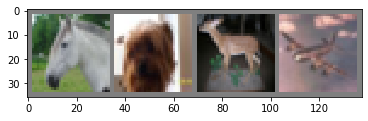

In [5]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def imshow(img):
    # 输入数据： torch.tensor [c,h,w]
    img = img / 2 + 0.5
    nping = img.numpy()
    nping = np.transpose(nping, (1,2,0)) #[h,w,c]
    plt.imshow(nping)
    
dataiter = iter(trainloader) # 随机加载一个mini batch
images, labels = dataiter.next() 
imshow(torchvision.utils.make_grid(images))

In [6]:
# 定义神经网络的结构 
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self): #定义神经网络结构，输入数据 3*32*32 （一个频道的图片）
        super(Net, self).__init__()
        # 第一层 卷积层 输入频道1，输出频道6，卷积3*3
        self.conv1 = nn.Conv2d(3,6,3)
        # 第二层 卷积层 输入频道6，输出频道16，卷积3*3
        self.conv2 = nn.Conv2d(6,16,3)
        # 第三层 全连接层 输入维度16*（32-2-2）*（32-2*2），输出维度512 
        self.fc1 = nn.Linear(16*28*28, 512)
        # 第四层 全连接层 输入维度512， 输出维度64
        self.fc2 = nn.Linear(512,64)
        # 第五层 全连接层 输入维度64， 输出维度10
        self.fc3 = nn.Linear(64,10)
    # 定义数据流向
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        
        x = x.view(-1, 16*28*28)
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)       

        x = self.fc3(x)
        return x 

In [10]:
net = Net()

In [11]:
# 定义损失函数
criterion = nn.CrossEntropyLoss() # 训练分离器最常用。

In [12]:
# 定义权重更新规则 
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr= 0.001, momentum = 0.9)

In [13]:
# 开始训练
# 轮数为epoch, 2轮都太张时间了，半小时。 
for epoch in range(1): 
    # 步数为i
    for i, data in enumerate(trainloader):
        images, lables = data 
        outputs = net(images)
        loss = criterion(outputs, labels) #计算损失
        optimizer.zero_grad() # 梯度清零
        loss.backward() # 反向训练
        optimizer.step() # 更新一次
        if(i%1000 == 0):
            print('Epoch: %d, Step: %d, Loss: %.3f' %(epoch,i, loss.item()))

Epoch: 0, Step: 0, Loss: 2.293
Epoch: 0, Step: 1000, Loss: 1.384
Epoch: 0, Step: 2000, Loss: 1.392
Epoch: 0, Step: 3000, Loss: 1.409
Epoch: 0, Step: 4000, Loss: 1.393
Epoch: 0, Step: 5000, Loss: 1.391
Epoch: 0, Step: 6000, Loss: 1.393
Epoch: 0, Step: 7000, Loss: 1.391
Epoch: 0, Step: 8000, Loss: 1.381
Epoch: 0, Step: 9000, Loss: 1.390
Epoch: 0, Step: 10000, Loss: 1.390
Epoch: 0, Step: 11000, Loss: 1.384
Epoch: 0, Step: 12000, Loss: 1.386
Epoch: 1, Step: 0, Loss: 1.381
Epoch: 1, Step: 1000, Loss: 1.386
Epoch: 1, Step: 2000, Loss: 1.384
Epoch: 1, Step: 3000, Loss: 1.385
Epoch: 1, Step: 4000, Loss: 1.392
Epoch: 1, Step: 5000, Loss: 1.388
Epoch: 1, Step: 6000, Loss: 1.386
Epoch: 1, Step: 7000, Loss: 1.394
Epoch: 1, Step: 8000, Loss: 1.383
Epoch: 1, Step: 9000, Loss: 1.391
Epoch: 1, Step: 10000, Loss: 1.379
Epoch: 1, Step: 11000, Loss: 1.395
Epoch: 1, Step: 12000, Loss: 1.385


学习速率减低，波动减少，速度变慢。 

可能因此随机图片，造成另一个波动。 

In [15]:
# 测试模型
# 得到准确率
correct = 0.0
total = 0.0 
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images) # 得到该图在每个类的概率
        _, predicted = torch.max(outputs.data, 1) # 得到最大概率的分类
        correct += (predicted == labels).sum() # minibach 
        total += labels.size(0)
        
print('准确率: ', float(correct)/total)

准确率:  0.1205


In [16]:
# 保存模型
torch.save(net.state_dict(), './model.pt')

In [17]:
# 空模型的正确率：0.0973
net_2 = Net()

correct = 0.0
total = 0.0 
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net_2(images) # 得到该图在每个类的概率
        _, predicted = torch.max(outputs.data, 1) # 得到最大概率的分类
        correct += (predicted == labels).sum() # minibach 
        total += labels.size(0)
        
print('准确率: ', float(correct)/total)

准确率:  0.0973


In [18]:
# 载入模型
net_2.load_state_dict(torch.load('./model.pt'))

<All keys matched successfully>

In [19]:
correct = 0.0
total = 0.0 
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net_2(images) # 得到该图在每个类的概率
        _, predicted = torch.max(outputs.data, 1) # 得到最大概率的分类
        correct += (predicted == labels).sum() # minibach 
        total += labels.size(0)
        
print('准确率: ', float(correct)/total)

准确率:  0.1205
